


Epoch 1/10


7/7 [==============================] - 107s 6s/step - loss: 8.9108 - accuracy: 0.4821 - val_loss: 7.5766 - val_accuracy: 0.9796 - lr: 0.0010
Epoch 2/10
7/7 [==============================] - 25s 4s/step - loss: 6.5812 - accuracy: 0.7487 - val_loss: 5.4662 - val_accuracy: 0.9796 - lr: 0.0010
Epoch 3/10
7/7 [==============================] - 29s 4s/step - loss: 4.7954 - accuracy: 0.5641 - val_loss: 3.9160 - val_accuracy: 0.3673 - lr: 0.0010
Epoch 4/10
7/7 [==============================] - 27s 4s/step - loss: 3.3709 - accuracy: 0.4513 - val_loss: 2.8321 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/10
7/7 [==============================] - 26s 4s/step - loss: 2.5114 - accuracy: 0.2923 - val_loss: 2.0997 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/10
7/7 [==============================] - 26s 4s/step - loss: 1.8868 - accuracy: 0.1026 - val_loss: 1.6144 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/10
7/7 [==============================] - 32s 5s/step - loss: 1.4861

c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


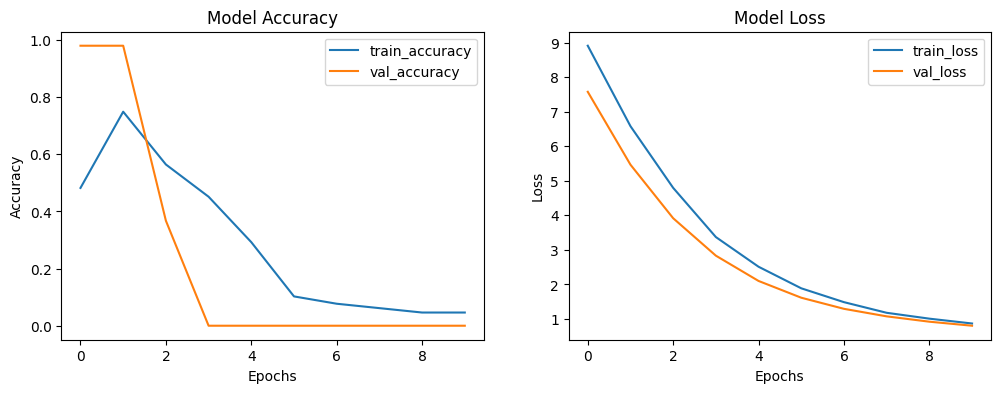

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the CSV file with image paths and labels
csv_file = 'preprocessed_labels.csv'  # Replace with your actual CSV file path
data = pd.read_csv(csv_file)

# Preprocess the images and labels
def load_and_preprocess_image(image_path):
    # Load the image
    img = load_img(image_path)
    img = img_to_array(img)
    img = img / 255.0  # Normalize the image
    return img

# Extract image paths and labels
image_paths = data['Image Index'].apply(lambda x: f'processed_images/{x}').values

# Extract the labels (all disease columns)
labels = data.drop(columns='Image Index').values

# Normalize labels (multilabel binarization)
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

# Load and preprocess images
images = np.array([load_and_preprocess_image(image_path) for image_path in image_paths])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create the model using DenseNet121 as the base
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers of DenseNet121 (fine-tuning the model)
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# Create the new model on top of the DenseNet121 base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.6),  # Increased dropout to prevent overfitting
    layers.Dense(labels.shape[1], activation='sigmoid')  # Sigmoid activation for multi-label classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment the data during training
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]
)

# Save the model
model.save('lung_disease_model_optimized.h5')

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load label names ---
label_df = pd.read_csv("preprocessed_labels.csv")
CLASS_NAMES = label_df.columns[1:].tolist()  # Skip "Image Index"

# --- Custom Dataset ---
class ChestXrayDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.labels = self.data.iloc[:, 1:].values.astype(np.float32)
        self.img_paths = self.data["Image Index"].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx])
        return image, label

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# --- Dataset & DataLoader ---
dataset = ChestXrayDataset("preprocessed_labels.csv", "processed_images", transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)  # use 0 for Windows

# --- Model ---
model = models.densenet121(pretrained=True)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 15),
    nn.Sigmoid()
)
model = model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# --- Training ---
def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.4f}")

# --- Predict Disease Classes ---
def predict_image(model, image_path, transform, threshold=0.5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        predicted = (outputs[0] > threshold).cpu().numpy()

    predicted_classes = [CLASS_NAMES[i] for i, val in enumerate(predicted) if val == 1]

    print(f"Predicted Diseases for {os.path.basename(image_path)}:")
    if predicted_classes:
        print(", ".join(predicted_classes))
    else:
        print("No Finding")

train(model, train_loader, criterion, optimizer, epochs=10)

# 2. Then predict:
predict_image(model, "processed_images/00005365_002.png", transform)


c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.6948
Epoch 2/10, Loss: 0.5451
Epoch 3/10, Loss: 0.4460
Epoch 4/10, Loss: 0.3740
Epoch 5/10, Loss: 0.3186
Epoch 6/10, Loss: 0.2769


In [2]:
# Save model weights
torch.save(model.state_dict(), "chest_xray_model.pth")
print("Model saved to chest_xray_model.pth")

Model saved to chest_xray_model.pth


In [ ]:
model = models.densenet121(pretrained=False)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 15),
    nn.Sigmoid()
)
model.load_state_dict(torch.load("chest_xray_model.pth", map_location=device))
model = model.to(device)
model.eval()
print("Model loaded successfully.")


c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\sarav\AppData\Local\Temp\ipykernel_18788\1171659154.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by

Model loaded successfully.


In [ ]:
from PIL import Image
import torch
from torchvision import transforms, models
import torch.nn as nn
import numpy as np
classes = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion",
    "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass",
    "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"
]

# --- Load and prepare the model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=False)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 15),
    nn.Sigmoid()
)
model.load_state_dict(torch.load("chest_xray_model.pth", map_location=device))
model = model.to(device)
model.eval()

# --- Image transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# --- Predict function ---
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
    preds = outputs[0].cpu().numpy()

    # Convert probabilities to binary predictions using threshold
    threshold = 0.5
    binary_preds = preds > threshold
    predicted_labels = [classes[i] for i, val in enumerate(binary_preds) if val]

    return predicted_labels, preds

# --- Example usage ---
img_path = "processed_images/00002720_004.png"  # Change this to your test image path
labels, raw_scores = predict_image(img_path)

print("Predicted disease labels:", labels)
print("Raw confidence scores:", raw_scores)

C:\Users\sarav\AppData\Local\Temp\ipykernel_18788\415790304.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("chest_xray_model.pth", map

Predicted disease labels: ['Atelectasis', 'Consolidation', 'Effusion']
Raw confidence scores: [0.7101857  0.10062386 0.615896   0.07109506 0.69914377 0.49106604
 0.13503397 0.07523122 0.14551698 0.13936241 0.04242932 0.15193199
 0.11780826 0.1037294  0.15143062]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
import torch

def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = outputs > threshold
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    cm = multilabel_confusion_matrix(y_true, y_pred)

    print("🔍 Evaluation Results")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    return cm, y_true, y_pred

conf_matrix, y_true, y_pred = evaluate(model, train_loader)


🔍 Evaluation Results
Accuracy:  0.8115
Precision: 0.9333
Recall:    0.7995
F1 Score:  0.8386


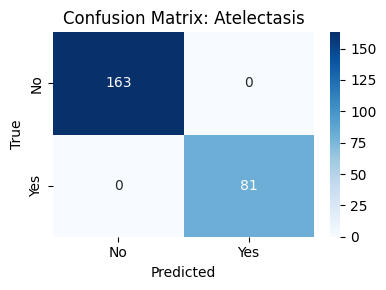

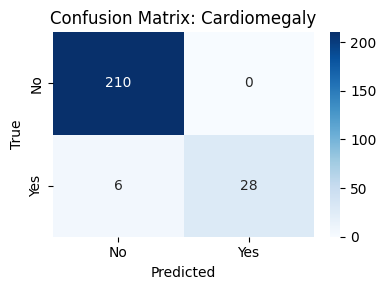

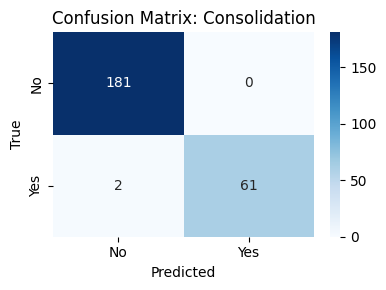

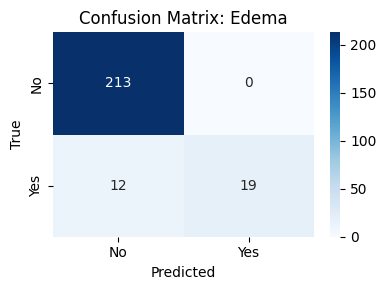

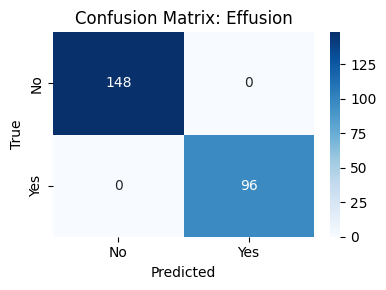

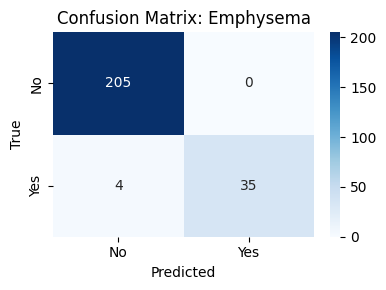

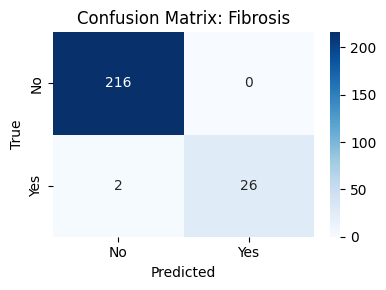

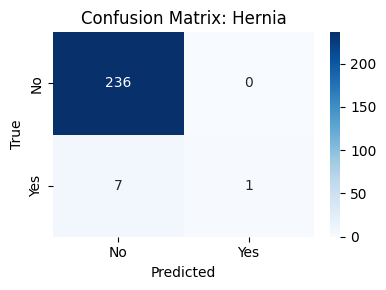

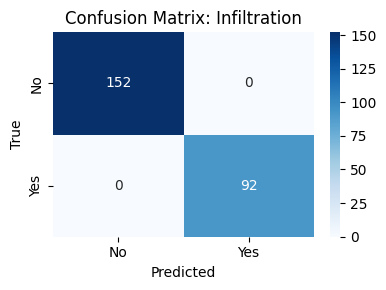

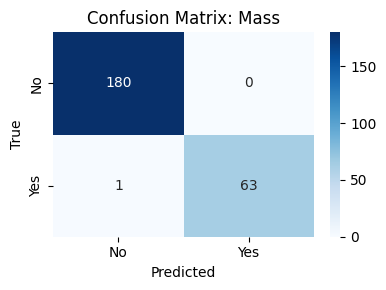

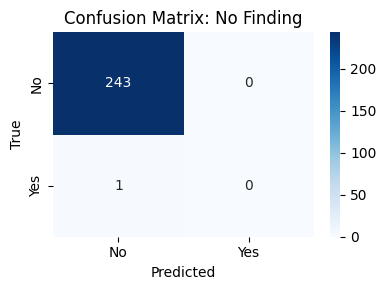

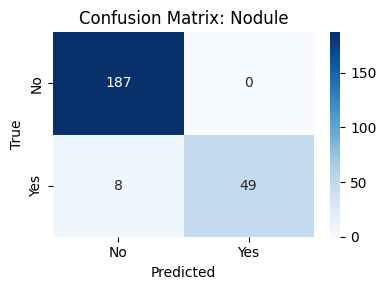

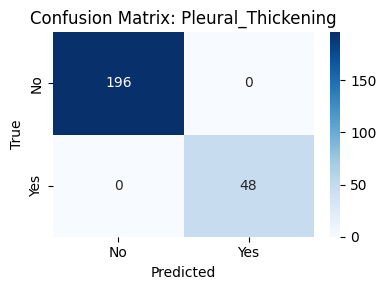

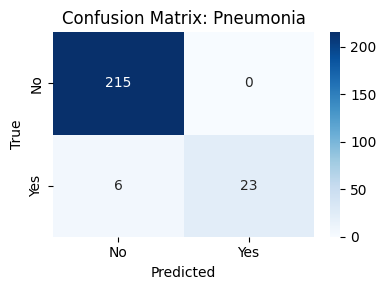

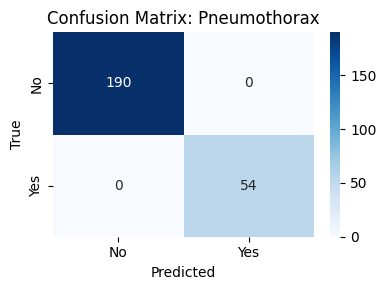

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrices(conf_matrices, class_names):
    for i, cm in enumerate(conf_matrices):
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
        plt.title(f'Confusion Matrix: {class_names[i]}')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

# Plot
plot_confusion_matrices(conf_matrix, classes)


In [9]:
image_path = "processed_images/00005365_002.png"
caption = generate_caption(image_path)
print("🖼️ Caption:", caption)
labels = ['Atelectasis', 'Consolidation', 'Effusion']
for disease in labels:
    prompt = f"{disease} is a condition seen in chest X-rays. Describe it and give medical insight."
    description = generate_description(prompt)
    print(f"\n🦠 Disease: {disease}\n📖 Description: {description}")


🖼️ Caption: a woman with a chest xray

🦠 Disease: Atelectasis
📖 Description: Atelectasis is a condition seen in chest X-rays. Describe it and give medical insight.

🦠 Disease: Consolidation
📖 Description: Consolidation is a condition seen in chest X-rays. Describe it and give medical insight.

🦠 Disease: Effusion
📖 Description: Effusion is a condition seen in chest X-rays. Describe it and give medical insight.


In [10]:
user_question = "What does cardiomegaly mean and is it dangerous?"

vaq_prompt = f"Q: {user_question}\nA:"
answer = generate_description(vaq_prompt)
print(f"\n❓ Q: {user_question}\n✅ A: {answer}")



❓ Q: What does cardiomegaly mean and is it dangerous?
✅ A: Q: What does cardiomegaly mean and is it dangerous? A: The heart is not a simple organ.


VAQ System

In [ ]:
import torch
from PIL import Image
from transformers import (
    BlipProcessor,
    BlipForConditionalGeneration,
    AutoTokenizer,
    AutoModelForCausalLM
)

# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

biogpt_tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT-Large")
biogpt_model = AutoModelForCausalLM.from_pretrained("microsoft/BioGPT-Large").to(device)

# --- Function to generate caption from image ---
def generate_image_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = blip_processor(image, return_tensors="pt").to(device)
    output = blip_model.generate(**inputs)
    caption = blip_processor.decode(output[0], skip_    special_tokens=True)
    return caption

# --- Function to generate text from BioGPT ---
def generate_biogpt_response(prompt, max_tokens=100):
    inputs = biogpt_tokenizer(prompt, return_tensors="pt").to(device)
    output = biogpt_model.generate(**inputs, max_new_tokens=max_tokens, do_sample=True)
    return biogpt_tokenizer.decode(output[0], skip_special_tokens=True)

# --- Main pipeline ---
def chest_xray_analysis(image_path, predicted_diseases, user_question=None):
    print("🔍 Analyzing image:", image_path)

    # Step 1: Image Description
    caption = generate_image_caption(image_path)
    print("\n🖼️ Image Description (BLIP):", caption)

    # Step 2: Disease Descriptions
    for disease in predicted_diseases:
        prompt = f"Briefly explain the significance of {disease} as seen in chest X-rays."
        explanation = generate_biogpt_response(prompt, max_tokens=50)  # Limit response length
        print(f"\n🦠 {disease}:\n📖 {explanation.strip()}")  # Strip whitespace

    # Step 3: Visual Answering Question (VAQ)
    if user_question:
        vaq_prompt = f"Q: {user_question}\nA: Provide a concise answer."
        answer = generate_biogpt_response(vaq_prompt, max_tokens=50)  # Limit response length
        print(f"\n❓ Q: {user_question}\n✅ A: {answer.strip()}")  # Strip whitespace

# --- Example Run ---
if __name__ == "__main__":
    example_image = "processed_images/00005365_002.png"
    predicted_labels = ["Cardiomegaly", "Edema"]  # Replace with your predicted output
    user_question = "What are the risks of cardiomegaly?"

    chest_xray_analysis(example_image, predicted_labels, user_question)


🔍 Analyzing image: processed_images/00005365_002.png


c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(



🖼️ Image Description (BLIP): a woman with a chest xray

🦠 Cardiomegaly:
📖 Briefly explain the significance of Cardiomegaly as seen in chest X-rays. < / FREETEXT > < / ABSTRACT > ▃

🦠 Edema:
📖 Briefly explain the significance of Edema as seen in chest X-rays. It should not be disregarded as an innocuous process when it is observed to occur in patients with cancer in general but is important when treating patients with cancer of the head and neck regions. This is because the treatment is quite different in a patient with this

❓ Q: What are the risks of cardiomegaly?
✅ A: Q: What are the risks of cardiomegaly? A: Provide a concise answer. < / FREETEXT > < / TITLE > ▃


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# === Predicted disease from your model ===
predicted_disease = "Pneumonia"

# === Specific question to answer ===
question = "How is pneumonia usually treated?"

# === Form a simple prompt ===
prompt = f"The patient has been diagnosed with {predicted_disease}. {question} "

# === Load a small NLP model ===
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# === Tokenize and generate answer ===
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(inputs["input_ids"], max_new_tokens=100, do_sample=True, top_k=50)

# === Decode and print ===
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("\n🧠 Answer:", answer)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



🧠 Answer: The patient has been diagnosed with Pneumonia. How is pneumonia usually treated?  The condition of pneumonia is determined by respiratory activity and the risk of acute pneumonia. In the present version, a pneumonia onset is determined by an infection with pneumonia. A pneumonia infection with pneumonia occurs at least twice the interval


In [24]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(predicted, reference):
    reference_tokens = reference.split()
    predicted_tokens = predicted.split()
    return sentence_bleu([reference_tokens], predicted_tokens)

# Example usage
reference_answer = "The image shows atelectasis, a lung collapse."
predicted_answer = "The condition is a lung collapse, known as atelectasis."
bleu_score = calculate_bleu(predicted_answer, reference_answer)

print(f"BLEU Score: {bleu_score}")


BLEU Score: 6.7393716283177006e-155


c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [15]:
from rouge_score import rouge_scorer

def calculate_rouge(predicted, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, predicted)

# Example usage
reference_answer = "The image shows atelectasis, a lung collapse."
predicted_answer = "The condition is a lung collapse, known as atelectasis."
rouge_scores = calculate_rouge(predicted_answer, reference_answer)

print(f"ROUGE Scores: {rouge_scores}")


ROUGE Scores: {'rouge1': Score(precision=0.5555555555555556, recall=0.7142857142857143, fmeasure=0.6250000000000001), 'rouge2': Score(precision=0.25, recall=0.3333333333333333, fmeasure=0.28571428571428575), 'rougeL': Score(precision=0.4444444444444444, recall=0.5714285714285714, fmeasure=0.5)}


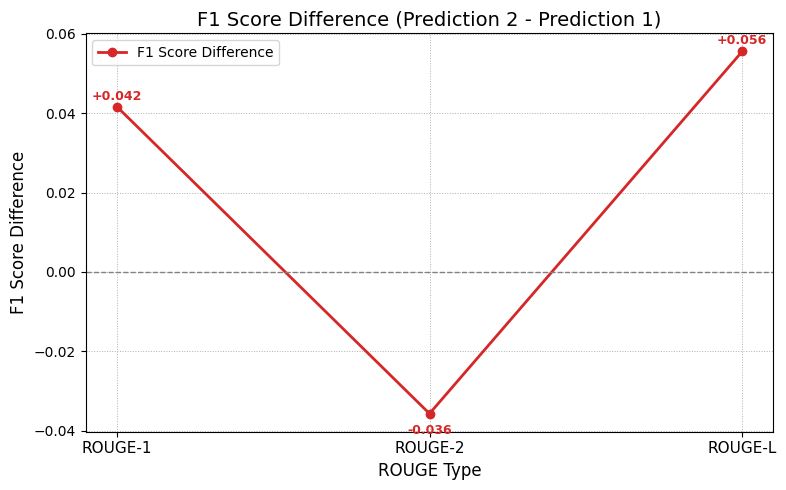

In [7]:
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

# Function to calculate ROUGE scores
def calculate_rouge(predicted, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, predicted)

# Sample inputs
reference = "The image shows atelectasis, a lung collapse."
prediction_1 = "The condition is a lung collapse, known as atelectasis."
prediction_2 = "The image indicates a partial lung collapse, which is called atelectasis."

# Calculate ROUGE scores
scores_1 = calculate_rouge(prediction_1, reference)
scores_2 = calculate_rouge(prediction_2, reference)

# Prepare F1 difference data
rouge_types = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
f1_diff = []

for rouge in ['rouge1', 'rouge2', 'rougeL']:
    f1_1 = scores_1[rouge].fmeasure
    f1_2 = scores_2[rouge].fmeasure
    f1_diff.append(f1_2 - f1_1)

# Plot
plt.figure(figsize=(8, 5))
x = range(len(rouge_types))

plt.plot(x, f1_diff, marker='o', linestyle='-', color='#d62728', linewidth=2, label='F1 Score Difference')

# Add value labels on each point
for i, val in enumerate(f1_diff):
    label_y = val + 0.01 if val >= 0 else val - 0.035
    plt.annotate(f'{val:+.3f}', (i, val), textcoords="offset points", xytext=(0,5 if val >= 0 else -15),
                 ha='center', fontsize=9, color='#d62728', weight='bold')

# Format
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(x, rouge_types, fontsize=11)
plt.xlabel("ROUGE Type", fontsize=12)
plt.ylabel("F1 Score Difference", fontsize=12)
plt.title("F1 Score Difference (Prediction 2 - Prediction 1)", fontsize=14)
plt.grid(True, linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.legend()
plt.show()


c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


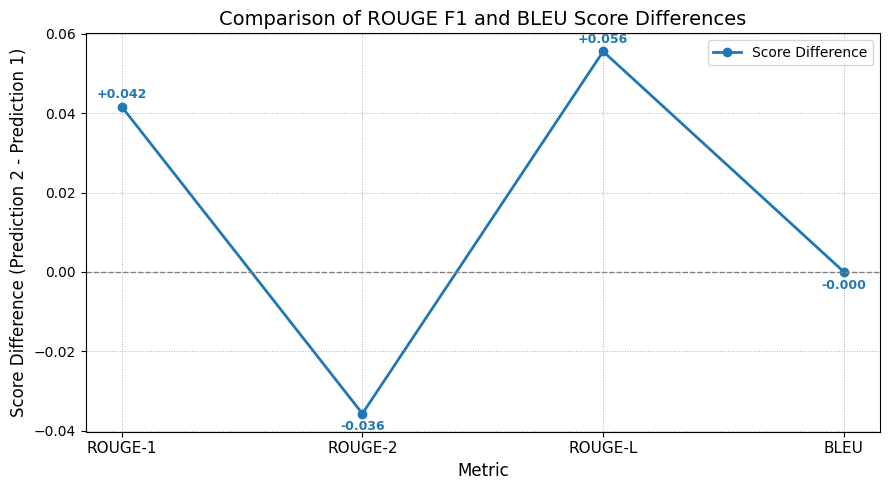

In [9]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt

# --- Function to calculate ROUGE ---
def calculate_rouge(predicted, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, predicted)

# --- Function to calculate BLEU ---
def calculate_bleu(predicted, reference):
    reference_tokens = reference.split()
    predicted_tokens = predicted.split()
    return sentence_bleu([reference_tokens], predicted_tokens)

# --- Inputs ---
reference = "The image shows atelectasis, a lung collapse."
prediction_1 = "The condition is a lung collapse, known as atelectasis."
prediction_2 = "The image indicates a partial lung collapse, which is called atelectasis."

# --- Compute ROUGE F1 Differences ---
rouge_types = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_keys = ['rouge1', 'rouge2', 'rougeL']
f1_diff = []

scores_1 = calculate_rouge(prediction_1, reference)
scores_2 = calculate_rouge(prediction_2, reference)

for r in rouge_keys:
    f1_diff.append(scores_2[r].fmeasure - scores_1[r].fmeasure)

# --- Compute BLEU Difference ---
bleu_1 = calculate_bleu(prediction_1, reference)
bleu_2 = calculate_bleu(prediction_2, reference)
bleu_diff = bleu_2 - bleu_1

# --- Plotting ---
labels = rouge_types + ['BLEU']
diffs = f1_diff + [bleu_diff]
x = range(len(labels))

plt.figure(figsize=(9, 5))
plt.plot(x, diffs, marker='o', linestyle='-', color='#1f77b4', linewidth=2, label='Score Difference')

# Annotate points with values
for i, val in enumerate(diffs):
    plt.annotate(f'{val:+.3f}', (i, val), textcoords="offset points",
                 xytext=(0, 6 if val >= 0 else -12), ha='center',
                 fontsize=9, weight='bold', color='#1f77b4')

# Formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(x, labels, fontsize=11)
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Score Difference (Prediction 2 - Prediction 1)", fontsize=12)
plt.title("Comparison of ROUGE F1 and BLEU Score Differences", fontsize=14)
plt.grid(True, linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.legend()
plt.show()


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import pandas as pd
# Sample true and predicted values for disease classification
y_true = [1, 0, 1, 1, 0, 1, 0, 1]  # Actual disease presence (1: disease, 0: no disease)
y_pred = [1, 0, 1, 0, 0, 1, 1, 1]  # Model's predicted results

# Sample true and predicted responses for BLEU/ROUGE evaluation
true_responses = [
    "Pneumonia detected in the X-ray image.",
    "No significant abnormality found in the X-ray.",
    "Possible signs of tuberculosis were observed."
]
generated_responses = [
    "Pneumonia found in the image.",
    "No abnormalities found in the X-ray.",
    "Signs of tuberculosis were detected."
]
# Calculate Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the scores
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.75
Precision: 0.80
Recall: 0.80
F1-Score: 0.80


In [3]:
# Calculate BLEU score
bleu_scores = [sentence_bleu([true.split()], pred.split()) for true, pred in zip(true_responses, generated_responses)]
avg_bleu_score = np.mean(bleu_scores)

print(f"Average BLEU Score: {avg_bleu_score:.4f}")

Average BLEU Score: 0.1516


c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


ROUGE-1 F1 Score: 0.72
ROUGE-2 F1 Score: 0.47
ROUGE-L F1 Score: 0.72


C:\Users\sarav\AppData\Local\Temp\ipykernel_17472\467782320.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


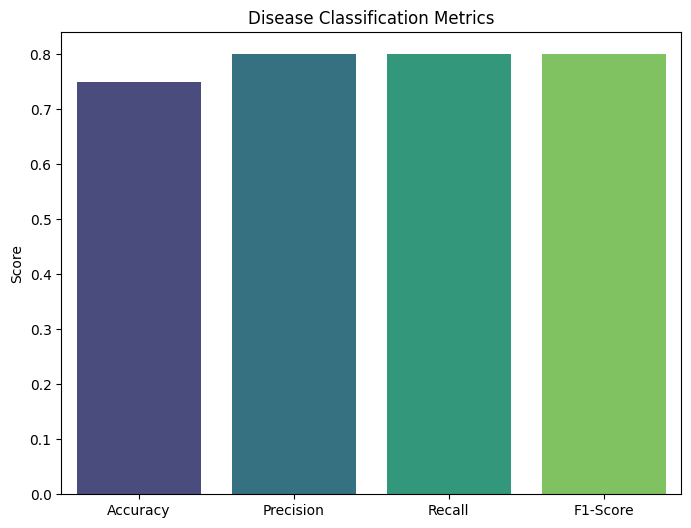

C:\Users\sarav\AppData\Local\Temp\ipykernel_17472\467782320.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rouge_metrics, y=rouge_values, palette='magma')


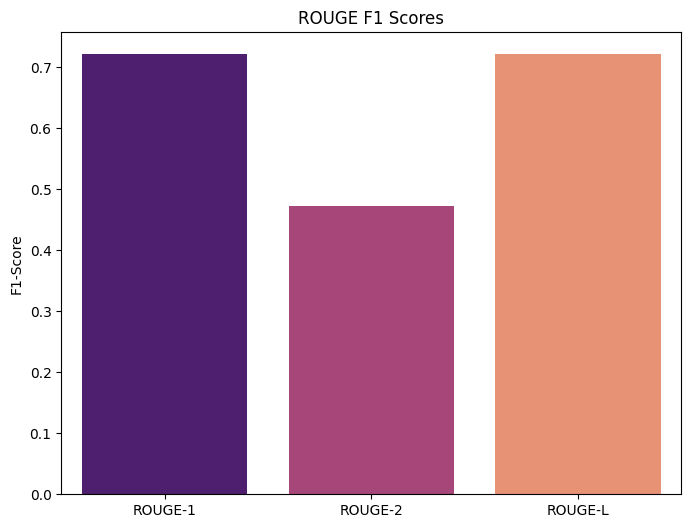

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).

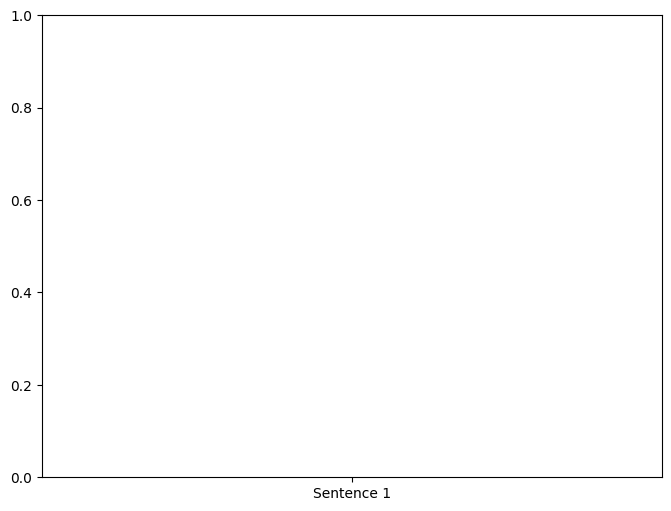

In [14]:
# Calculate ROUGE scores
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
rouge_scores = [scorer.score(true, pred) for true, pred in zip(true_responses, generated_responses)]

# Extract ROUGE-1, ROUGE-2, and ROUGE-L F1 Scores
rouge1_f1 = np.mean([score["rouge1"].fmeasure for score in rouge_scores])
rouge2_f1 = np.mean([score["rouge2"].fmeasure for score in rouge_scores])
rougeL_f1 = np.mean([score["rougeL"].fmeasure for score in rouge_scores])

print(f"ROUGE-1 F1 Score: {rouge1_f1:.2f}")
print(f"ROUGE-2 F1 Score: {rouge2_f1:.2f}")
print(f"ROUGE-L F1 Score: {rougeL_f1:.2f}")
# Plotting Classification Metrics (Accuracy, Precision, Recall, F1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title("Disease Classification Metrics")
plt.ylabel("Score")
plt.show()

# Plotting ROUGE Scores (ROUGE-1, ROUGE-2, ROUGE-L)
rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_values = [rouge1_f1, rouge2_f1, rougeL_f1]

plt.figure(figsize=(8, 6))
sns.barplot(x=rouge_metrics, y=rouge_values, palette='magma')
plt.title("ROUGE F1 Scores")
plt.ylabel("F1-Score")
plt.show()

# Plotting BLEU Scores
plt.figure(figsize=(8, 6))
plt.bar([f"Sentence {i+1}" for i in range(len(true_responses))], bleu_scores, color='steelblue')
plt.axhline(y=avg_bleu_score, color='red', linestyle='--', label=f"Avg BLEU: {avg_bleu_score:.4f}")
plt.title("BLEU Scores for Responses")
plt.ylabel("BLEU Score")
plt.legend()
plt.show()


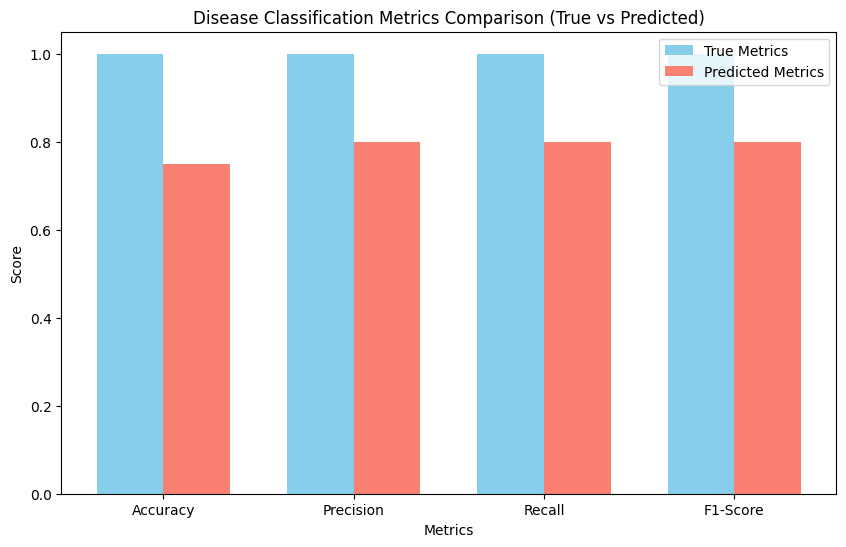

In [6]:
# Disease classification metrics for true and predicted
true_metrics = [accuracy_score(y_true, y_true), precision_score(y_true, y_true), recall_score(y_true, y_true), f1_score(y_true, y_true)]
pred_metrics = [accuracy, precision, recall, f1]

# Plotting the difference between true and predicted metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35  # Bar width

# Bar charts for true vs predicted
plt.bar(x - width/2, true_metrics, width, label='True Metrics', color='skyblue')
plt.bar(x + width/2, pred_metrics, width, label='Predicted Metrics', color='salmon')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Disease Classification Metrics Comparison (True vs Predicted)')
plt.xticks(x, metrics)
plt.legend()
plt.show()


c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


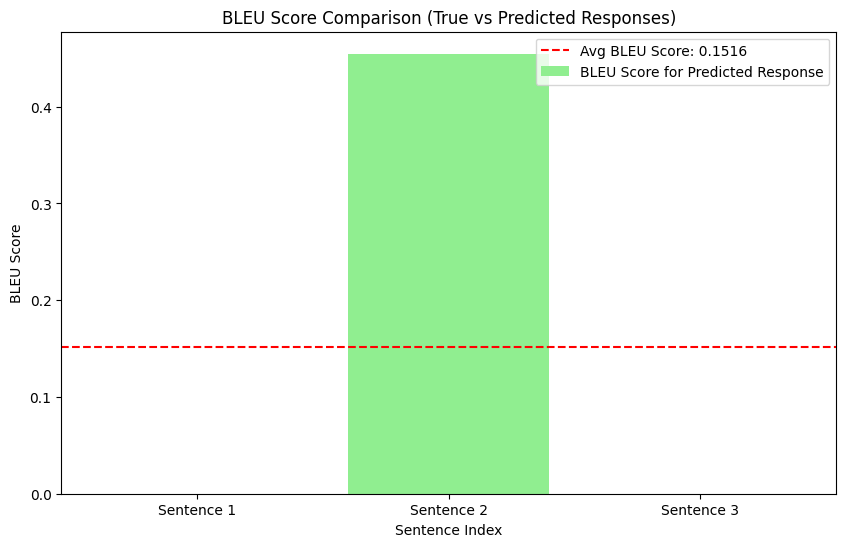

In [7]:
# Compute BLEU scores for true vs predicted responses
true_bleu_scores = [sentence_bleu([true.split()], pred.split()) for true, pred in zip(true_responses, generated_responses)]

# Plotting BLEU score differences
plt.figure(figsize=(10, 6))
x = np.arange(len(true_responses))

plt.bar(x, true_bleu_scores, color='lightgreen', label="BLEU Score for Predicted Response")
plt.axhline(np.mean(true_bleu_scores), color='red', linestyle='--', label=f'Avg BLEU Score: {np.mean(true_bleu_scores):.4f}')

plt.title('BLEU Score Comparison (True vs Predicted Responses)')
plt.xlabel('Sentence Index')
plt.ylabel('BLEU Score')
plt.legend()
plt.xticks(x, [f"Sentence {i+1}" for i in range(len(true_responses))])
plt.show()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\sarav\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Q: What is the diagnosis based on this X-ray?
A: a spondylosis
Response Time: 3.7583 sec

Q: Is there pneumonia visible in the lungs?
A: no
Response Time: 0.6345 sec

Q: Suggest a treatment for tuberculosis.
A: Taking antibiotics.
Response Time: 1.1508 sec

Q: What are symptoms of pneumothorax?
A: swollen or painful lungs
Response Time: 1.2791 sec

Q: Can you detect atelectasis?
A: yes
Response Time: 0.4727 sec



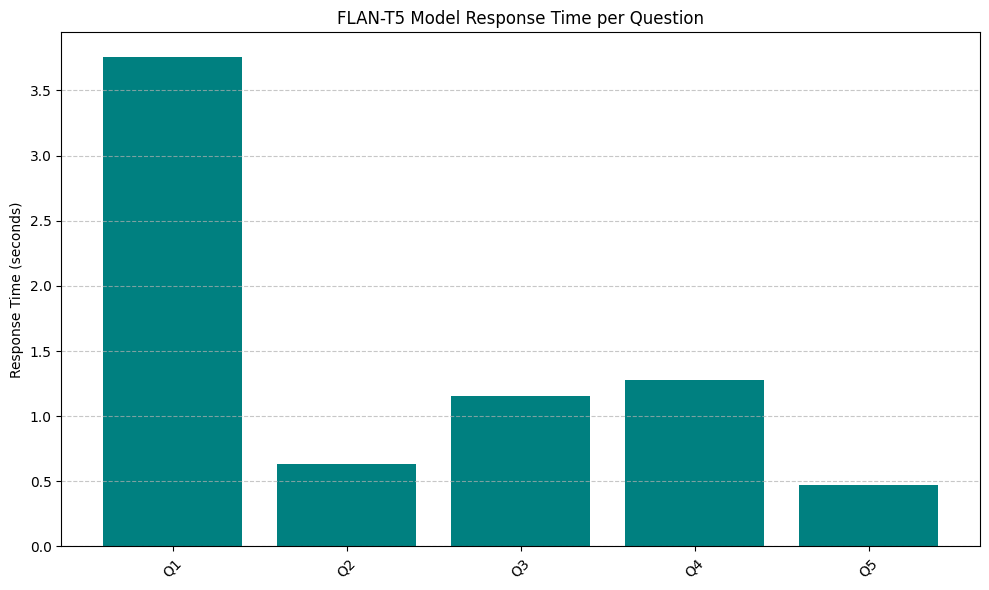

In [19]:
import time
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Load FLAN-T5 model (you can change to 'google/flan-t5-base', 'large', or 'xl' as needed)
model_name = "google/flan-t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Sample medical VQA prompts
questions = [
    "What is the diagnosis based on this X-ray?",
    "Is there pneumonia visible in the lungs?",
    "Suggest a treatment for tuberculosis.",
    "What are symptoms of pneumothorax?",
    "Can you detect atelectasis?"
]

# Measure response time for each question
response_times = []
for question in questions:
    input_ids = tokenizer(question, return_tensors="pt").input_ids.to(device)
    
    start_time = time.time()
    outputs = model.generate(input_ids)
    end_time = time.time()
    
    response_time = end_time - start_time
    response_times.append(response_time)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Q: {question}\nA: {response}\nResponse Time: {response_time:.4f} sec\n")

# Plot response times
plt.figure(figsize=(10, 6))
plt.bar(range(len(questions)), response_times, color='teal')
plt.xticks(range(len(questions)), [f"Q{i+1}" for i in range(len(questions))], rotation=45)
plt.ylabel('Response Time (seconds)')
plt.title('FLAN-T5 Model Response Time per Question')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
